# 03 GPR Model Training

## General Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys  # nopep8
sys.path.append('../')  # nopep8

import os
import time
import pickle

import numpy as np
import pandas as pd
import chaospy as cp

import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from helper_functions import setup_plot, store_plot, get_joint

sns.set_theme(style="whitegrid", palette="bright")
bright_palette = sns.color_palette("bright")

from UQpy.surrogates import * # This is somehow required to not have warnings during fit

## Functions

### Data Selection

In [3]:
def load_sim_data(ipath, case_matrix, case_data):
    """
    Load and combine simulation data from case matrix and case data files.

    Args:
        ipath (str): Directory path to the data files.
        case_matrix (str): Filename of the case matrix CSV file.
        case_data (str): Filename of the case data CSV file.

    Returns:
        pandas.DataFrame: Combined DataFrame of cases and case data.
    """
    case_matrix_path = os.path.join(ipath, case_matrix)
    case_data_path = os.path.join(ipath, case_data)
    cases = pd.read_csv(case_matrix_path)
    case_data = pd.read_csv(case_data_path).sort_values(
        by=['Case']).reset_index(drop=True)
    return pd.concat([cases, case_data], axis=1)

def get_training_data(data, num_samples, num_replications, target, moment='mean'):
    """
    Retrieves a subset of training data with specified samples and replications, and computes the
    mean or standard deviation for the target variable based on the specified moment.

    Args:
        data (DataFrame): The complete dataset from which to extract training data.
        num_samples (int): The number of unique samples to retrieve.
        num_replications (int): The number of replications for each unique sample.
        target (str): The target variable to predict.
        moment (str, optional): The statistical moment to compute for the target variable over its replications.
                                Accepts 'mean' or 'sdv' (standard deviation). Defaults to 'mean'.

    Returns:
        numpy.ndarray: The feature matrix for training, with each unique sample's features replicated.
        numpy.ndarray: The feature matrix after applying the forward transformation from the joint distribution.
        pandas.Series: The target variable, aggregated by the specified moment across its replications.
    """

    target_mapping = {
        'Tower_Sdv': 'TwHtALxt_[m/s^]_sdv',
        'Tower_Max': 'TwHtALxt_[m/s^]_max',
        'Blade_Mean': 'RootMyb_[kN-m]_mean',
        'Blade_Max': 'RootMyb_[kN-m]_max'
    }
    target = target_mapping.get(target, None)
    filtered_df = pd.DataFrame()
    unique_samples = data.iloc[0:num_samples, 0:4]

    for i in range(len(unique_samples)):
        # Calculate the starting and ending row indices for each feature combination
        idx_list = [i+j*300 for j in range(num_replications)]
        temp_df = data.iloc[idx_list, :]
        filtered_df = pd.concat([filtered_df, temp_df])
    clean_df = filtered_df.dropna(how='any', axis=0)

    if len(filtered_df) - len(clean_df) == 0:
        pass
    else:
        print(
            f"{len(filtered_df) - len(clean_df)} rows were removed from the training data")

    if num_replications > 1:
        if moment == 'mean':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].mean().reset_index()
        elif moment == 'sdv':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].std().reset_index()

    x_train = clean_df.iloc[:, 0:4]
    y_train = clean_df.loc[:, target]
    distribution = get_joint(input_path_scada)
    x_train = np.array(x_train).T
    x_train_uniform = distribution.fwd(x_train)

    return x_train.T, x_train_uniform.T, y_train

def get_validation_data(data, target, moment='mean'):
    """
    Processes the validation data by grouping it according to feature combinations and computing the
    specified statistical moment (mean or standard deviation) of the target variable.

    Args:
        data (DataFrame): The dataset from which to extract validation data.
        target (str): The name of the target variable in the dataset.
        moment (str, optional): The statistical moment to compute for the target variable over its replications.
                                Accepts 'mean' for mean value or 'sdv' for standard deviation. Defaults to 'mean'.

    Returns:
        numpy.ndarray: The feature matrix for validation, with each unique sample's features.
        numpy.ndarray: The feature matrix after applying the forward transformation from the joint distribution.
        pandas.Series or numpy.ndarray: The aggregated target variable using the specified statistical moment.
    """

    target_mapping = {
        'Tower_Sdv': 'TwHtALxt_[m/s^]_sdv',
        'Tower_Max': 'TwHtALxt_[m/s^]_max',
        'Blade_Mean': 'RootMyb_[kN-m]_mean',
        'Blade_Max': 'RootMyb_[kN-m]_max'
    }
    target = target_mapping.get(target, None)

    if moment == 'mean':
        val_data = data.groupby(list(data.columns[0:4]))[
            target].mean().reset_index()
    elif moment == 'sdv':
        val_data = data.groupby(list(data.columns[0:4]))[
            target].std().reset_index()

    x_val = val_data.iloc[:, 0:4]
    y_val = val_data.loc[:, target]
    distribution = get_joint(input_path_scada)
    x_val = np.array(x_val).T
    x_val_uniform = distribution.fwd(x_val)

    return x_val.T, x_val_uniform.T, y_val

### Model Training and Validation

In [4]:
def custom_scorer(y_true, y_pred):
    """
    Calculate normalized root mean squared error (nRMSE), normalized mean absolute error (nMAE),
    and mean absolute error (MAE) between true and predicted values.

    The function normalizes the RMSE and MAE by the mean of the true values to account for scale variations
    and allow for comparison across different datasets.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing the following metrics:
              - nRMSE (float): Normalized root mean squared error.
              - nMAE (float): Normalized mean absolute error.
              - MAE (float): Mean absolute error.
    """
    # Calculate the mean of the true values
    true_mean = np.mean(y_true)

    # Calculate mean squared error and normalize it
    mse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(mse) / true_mean
    # Calculate mean absolute error and normalize it
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / true_mean

    r2 = r2_score(y_true, y_pred)

    # return {'nRMSE': nrmse, 'nMAE': nmae, 'MAE': mae, 'R2': r2}
    # return {'nRMSE': nrmse, 'nMAE': nmae, 'MAE': mae}
    return {'nRMSE': nrmse, 'nMAE': nmae}

def built_gpr(x_train_uniform, y_train):
    """
    Build and fit a Gaussian Process Regressor (GPR) model.

    Args:
        x_train_uniform (numpy.ndarray): The training feature data after uniform transformation.
        y_train (pandas.Series): The target values for training.

    Returns:
        GaussianProcessRegressor: The fitted GPR model.
        float: The elapsed time in seconds for fitting the model.
    """
    start_time = time.time()
    kernel = 1.0 * RBF(length_scale=[1, 1, 1, 1], length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
        noise_level=1e-2, noise_level_bounds=(1e-10, 1e10)
    )
    random_int = 42
    gpr = GaussianProcessRegressor(
        kernel=kernel, n_restarts_optimizer=20, random_state=random_int)
    gpr.fit(x_train_uniform, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return gpr, elapsed_time

def convergence_analysis_val(target, num_samples_range, df_train, df_test, moment):
    """
    Perform validation convergence analysis by training GPR models on training data 
    and evaluating them on a test set across a range of sample sizes and replications.

    Args:
        target (str): The target variable for prediction.
        num_samples_range (tuple): The range of sample sizes to train the model.
        num_replications_range (tuple): The range of replications for each sample size.
        df_train (DataFrame): The training dataset.
        df_test (DataFrame): The test dataset for validation.

    Returns:
        DataFrame: A DataFrame containing timing data for model training.
        DataFrame: A DataFrame containing the validation scores for each metric.
    """
    timing_data = []
    scores_data = []

    for num_samples in np.arange(*num_samples_range):
        _, x_train_uniform, y_train = get_training_data(
            df_train, num_samples, 30, target, moment)
        gpr, elapsed_time = built_gpr(x_train_uniform, y_train)
        scores = validate_gpr(gpr, df_test, target, moment)

        timing_data.append({
            'Num_Samples': num_samples,
            'Num_Replications': 30,
            'Time (s)': elapsed_time
        })

        for metric in scores.keys():
            scores_data.append({
                'Num_Samples': num_samples,
                'Num_Replications': 30,
                'Metric': metric,
                'Score': scores[metric]
            })

    # Convert lists of dictionaries to DataFrames
    df_timing = pd.DataFrame(timing_data)
    df_scores = pd.DataFrame(scores_data)

    return df_timing, df_scores

def validate_gpr(gpr_model, df_test, target, moment):
    """
    Validate a Gaussian Process Regressor model on a test dataset.

    Args:
        gpr_model (GaussianProcessRegressor): The trained GPR model to be validated.
        df_test (DataFrame): The test dataset for validation.
        target (str): The target variable for prediction.

    Returns:
        dict: A dictionary with mean validation scores for the predictions.
        dict: A dictionary with validation scores for the predicted standard deviations.
    """
    _, x_val_uniform, y_val = get_validation_data(
        df_test, target, moment=moment)

    y_pred_mean = gpr_model.predict(x_val_uniform)

    scores = custom_scorer(y_val, y_pred_mean)

    return scores

#### Helpers

In [5]:
def merge_moments(df_mean, df_sdv):
    """
    Merges two DataFrames containing the results for mean and standard deviation moments into a single DataFrame.

    Args:
        df_mean (DataFrame): A DataFrame containing the convergence analysis results for the mean moment.
        df_sdv (DataFrame): A DataFrame containing the convergence analysis results for the standard deviation moment.

    Returns:
        DataFrame: A concatenated DataFrame with results for both mean and standard deviation moments,
                   with an additional column indicating the 'Moment'.
    """

    df_mean['Moment'] = 'mean'
    df_sdv['Moment'] = 'sdv'
    return pd.concat([df_mean, df_sdv])

def convergence_wrapper(target, sample_range, df_train, df_test=None):
    """
    Runs the convergence analysis for a given target using specified parameters and returns the combined results
    for mean and standard deviation moments.

    Args:
        target (str): The target variable for the convergence analysis.
        poly_order_range (tuple): A tuple specifying the range of polynomial orders to test.
        regressor (str): The type of regression model to use for analysis.
        sample_range (tuple): A tuple specifying the range of sample sizes to test.
        num_replications (int): The number of times to replicate each sample for the analysis.
        strat (str): Strategy to use for analysis; 'cv' for cross-validation or 'val' for validation.
        df_train (DataFrame): The training dataset.
        df_test (DataFrame, optional): The testing dataset. Only required if 'strat' is 'val'.

    Returns:
        DataFrame: A DataFrame with the combined results of convergence analysis for both mean and standard deviation moments.

    Raises:
        ValueError: If the provided strategy is not one of 'cv' or 'val'.
    """
    _, mean_score = convergence_analysis_val(target, sample_range, df_train, df_test, moment='mean')
    _, sdv_score = convergence_analysis_val(target, sample_range, df_train, df_test, moment='sdv')

    return merge_moments(mean_score, sdv_score)

def store_models(model_dict):
    """
    Serializes and stores a dictionary of models to a pickle file.

    This function takes a dictionary containing models, serializes it using Python's pickle module,
    and writes it to a file named 'pce_models.pickle' located in the 'models' directory. 

    Args:
        model_dict (dict): A dictionary where keys are model identifiers and values are model objects.

    Returns:
        None: This function does not return any value. It saves the serialized object to a file.

    Raises:
        IOError: If the function cannot write to the specified file location.
        PicklingError: If an error occurs during the serialization process.
    """
    # Ensure 'models' directory exists, if not, create it
    os.makedirs('models', exist_ok=True)
    
    # Open the file and dump the dictionary into it using the highest pickle protocol
    with open(os.path.join(os.path.dirname(os.getcwd()), r"data\models\gpr_models.pickle"), 'wb') as handle:
        pickle.dump(model_dict, handle)
        
def display_scores_table(scores_dict):
    """
    Creates a table from the scores dictionary and prints it.

    Args:
        scores_dict (dict): A nested dictionary where the first key is the target,
                            the second key is the moment ('mean' or 'sdv'),
                            and the value is another dictionary with metric names and their corresponding scores.

    Returns:
        DataFrame: A pandas DataFrame representing the scores table for display.
    """
    score_rows = []

    # Collect data
    for target, moments in scores_dict.items():
        for moment, metrics in moments.items():
            for metric, value in metrics.items():
                score_rows.append({
                    'Target': target,
                    'Moment': moment,
                    'Metric': metric,
                    'Value': value.round(2)
                })

    scores_df = pd.DataFrame(score_rows)

    scores_pivot = scores_df.pivot_table(
        index=['Target', 'Moment'], columns='Metric', values='Value', aggfunc='first')

    scores_pivot.reset_index(inplace=True)

    return scores_pivot

### Plots

In [6]:
def plot_convergence_val(df, target):
    """
    Plot convergence results based on validation samples across different metrics.

    Args:
        df (DataFrame): A DataFrame containing validation scores for various metrics, moments, number of samples,
                        and replications.

    The function creates a FacetGrid of line plots with a separate subplot for each metric and moment. The results
    are color-coded by the number of replications to show how the scores change with the number of samples.
    """
    df_cp = df.copy()
    mapping_dict = {
        'mean': '$\mu$',
        'sdv': '$\sigma$'}

    df_cp.Moment = [mapping_dict[name] for name in df_cp.Moment]

    FIG_WIDTH, FIG_HEIGHT  = setup_plot(.6)
    FIG_WIDTH, FIG_HEIGHT = FIG_WIDTH*.7, FIG_HEIGHT*.7
    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/2
    g = sns.FacetGrid(df_cp, col="Metric", row='Moment', margin_titles=True, sharey=False,
                    height=sub_height,  aspect=sub_width / sub_height)

    g.map_dataframe(sns.lineplot, "Num_Samples", "Score", marker='o')

    g.set_axis_labels("Number of Samples", "Score [-]")
    g.set_titles(col_template="{col_name}",
                row_template="{row_name}")

    #store_plot(g, f"GPR_alt_conv_plot_{target}.png")

## Model Convergence

Here the model convergence behvaiour is analysed by training the models with varying number of training samples. Before model training, the samples are initially normalized using the Rosenblatt transformation, to ensure an even scaling of all features.
Using Scikit-learn, the GPRs are setup using the RBF kernel modified with a noise term. The parameter optimization is internally conducted using the log marginal likelihood method. We allow ten restarts of the optimizer to address the limitation that the chosen tuning method might not always find the global minima. 

Model fit is evaluated on the validation set using the normalized MAE and RMSE defined as follows:
$$\text{nMAE} = \frac{1}{N \cdot \bar{y}} \sum_{i=1}^{N} |y_i - \hat{y}_i|,$$

$$\text{nRMSE} = \frac{\sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}}{\bar{y}}.$$
Here, $y_i$ is the true value, $\hat{y}_i$ is the predicted value, $N$ is the number of data points, and $\bar{y}$ is the mean of the true values.


### Initial Setup

In [7]:
input_path_sim = os.path.join(os.path.dirname(os.getcwd()), r"data\simulation")
input_path_scada = os.path.join(os.path.dirname(os.getcwd()), r"data\scada")

df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
df_train = df.iloc[0:9000, :]
df_test = df.iloc[9000:, :]

timing_dict_cv = {}
timing_dict_val = {}
scoring_dict_cv = {}
scoring_dict_val = {}

sample_range = (50, 300+1, 50)

### Blade Loads
First the model convergence is plotted for the mean ($M_\text{blade,mean}$) and maximum ($M_\text{blade,max}$) flapwise bending moments at the blade root. Hereby, $\mu$ will represent the mean response over the seed-to-seed uncertainty while $\sigma$ is the corresponding standard deviation.

#### GPR - $M_\text{blade,mean}$

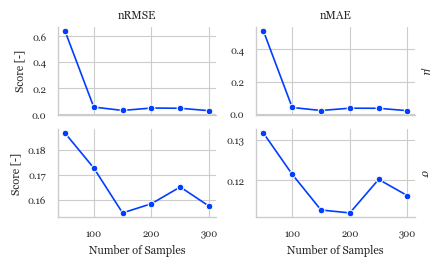

In [8]:
target = 'Blade_Mean'
scoring_dict_cv[target] = convergence_wrapper(target, sample_range, df_train, df_test)
plot_convergence_val(scoring_dict_cv[target], target)

#### GPR - $M_\text{blade,max}$

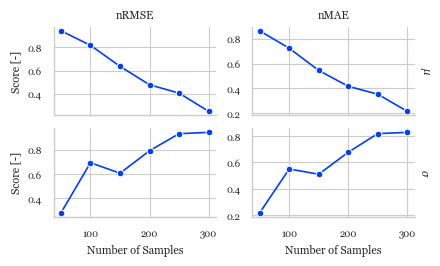

In [9]:
target = 'Blade_Max'
scoring_dict_cv[target] = convergence_wrapper(target, sample_range, df_train, df_test)
plot_convergence_val(scoring_dict_cv[target], target)

### Tower Acceleration
Next, model fits are explored for the standard ($\ddot{x}_\text{tower,std}$) deviation and maximum ($\ddot{x}_\text{tower,max}$) tower-top acceleration in the fore-aft direction.

#### GPR - $\ddot{x}_\text{tower,std}$

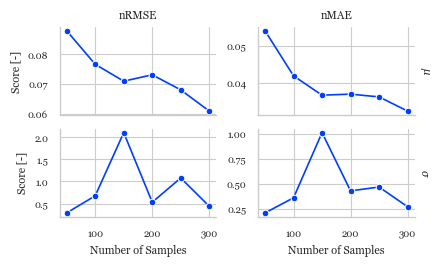

In [10]:
target = 'Tower_Sdv'
scoring_dict_cv[target] = convergence_wrapper(target, sample_range, df_train, df_test)
plot_convergence_val(scoring_dict_cv[target], target)

#### GPR - $\ddot{x}_\text{tower,max}$

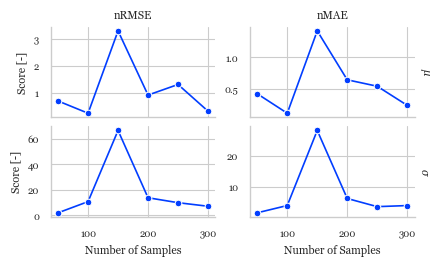

In [11]:
target = 'Tower_Max'
scoring_dict_cv[target] = convergence_wrapper(target, sample_range, df_train, df_test)
plot_convergence_val(scoring_dict_cv[target], target)

## Model Generation
This trains and stores the models for the case study application.

In [12]:
targets = ["Blade_Mean", "Blade_Max", "Tower_Sdv", "Tower_Max"]

gpr_models = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}
scores = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}
num_sampels = 300
num_replications = 30

df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
df_train = df.iloc[0:9000, :]
df_test = df.iloc[9000:, :]
dict_full_scores_cv = {}
dict_full_scores_val = {}

for target in targets:
    _, x_train_uniform, y_train_mean = get_training_data(
        df_train, num_sampels, num_replications, target, moment='mean')
    _, _, y_train_sdv = get_training_data(
        df_train, num_sampels, num_replications, target, moment='sdv')

    gpr_models[target]['mean'], _ = built_gpr(x_train_uniform, y_train_mean)
    gpr_models[target]['sdv'], _ = built_gpr(x_train_uniform, y_train_sdv)


    scores[target]['mean'] = validate_gpr(
        gpr_models[target]['mean'], df_test, target, 'mean')
    scores[target]['sdv'] = validate_gpr(
        gpr_models[target]['sdv'], df_test, target, 'sdv')

scores_table = display_scores_table(scores)
print(scores_table)
store_models(gpr_models)

Metric      Target Moment  nMAE  nRMSE
0        Blade_Max   mean  0.22   0.25
1        Blade_Max    sdv  0.83   0.94
2       Blade_Mean   mean  0.02   0.03
3       Blade_Mean    sdv  0.12   0.16
4        Tower_Max   mean  0.23   0.31
5        Tower_Max    sdv  3.94   7.09
6        Tower_Sdv   mean  0.03   0.06
7        Tower_Sdv    sdv  0.27   0.44
